In [76]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint

from pandas_datareader import data as pdr
from matplotlib import pyplot as plt
from scipy.stats import norm



sns.set_theme()
sns.set_style("whitegrid", {'grid.linestyle': '--'})
seq_col_brew = sns.color_palette("Blues_r", 4)
sns.set_palette(seq_col_brew)
%config InlineBackend.figure_format = 'retina'

In [77]:
snp500_weekly = pdr.get_data_yahoo("^GSPC", start="2011-12-28", end="2021-12-28", interval="wk")
snp500_weekly = snp500_weekly['Adj Close']
aud_weekly = pdr.get_data_yahoo("AUDUSD=X", start="2011-12-28", end="2021-12-28", interval="wk")
aud_weekly = aud_weekly['Adj Close']

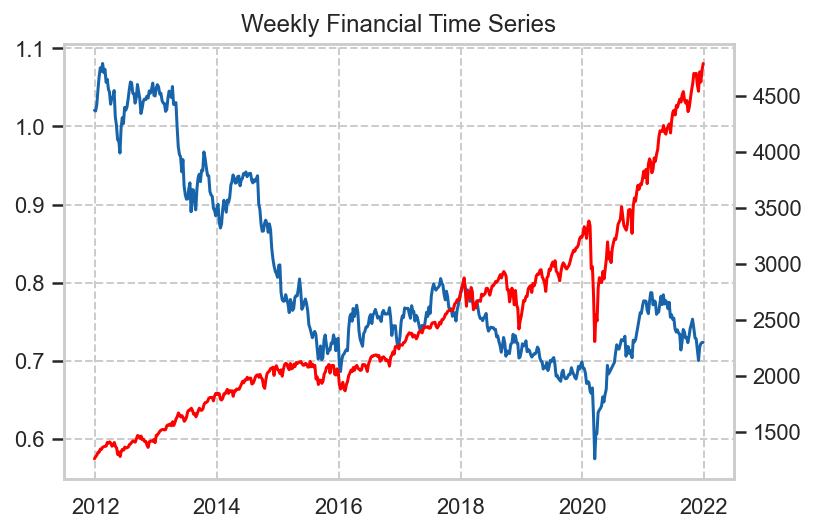

In [78]:
fig, ax = plt.subplots()
ax.plot(aud_weekly, label='AUD/USD')
ax2 = ax.twinx()
ax2.plot(snp500_weekly, color='red', label='S&P500')
ax2.grid(False)
plt.title('Weekly Financial Time Series')
plt.show()

In [79]:
snp500_weekly_returns = np.log(snp500_weekly/snp500_weekly.shift(1))
aud_weekly_returns = np.log(aud_weekly/aud_weekly.shift(1))

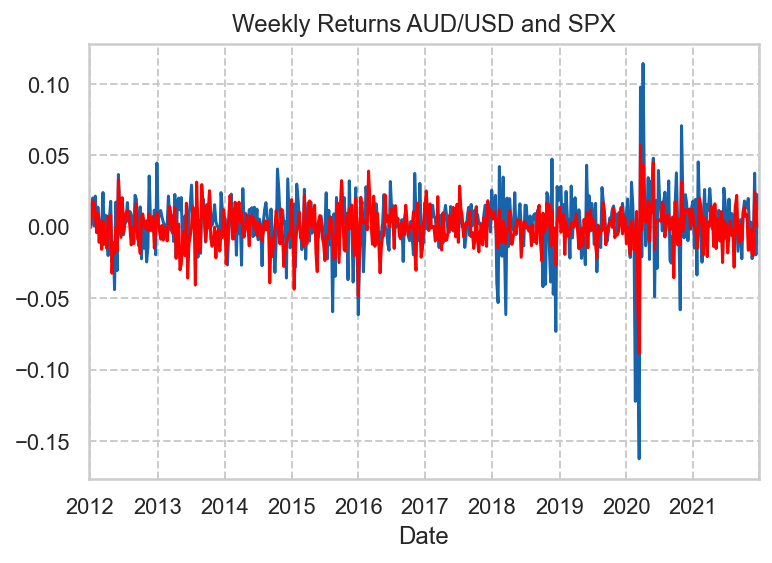

In [80]:
snp500_weekly_returns.plot()
aud_weekly_returns.plot(color='red')
plt.title('Weekly Returns AUD/USD and SPX')
plt.show()

In [81]:
aud_average_return = aud_weekly_returns.mean() * 365/7 * 100
snp500_average_return = snp500_weekly_returns.mean() * 365/7 * 100
print('Average AUD/USD weekly annualized return '+ str(aud_average_return) + '%')
print('Average SPX weekly annualized return '+ str(snp500_average_return) + '%')

Average AUD/USD weekly annualized return -3.4400656915675807%
Average SPX weekly annualized return 13.35099890730267%


(-0.6744897501960817, 0.6744897501960817)
-0.0065153102252620875 0.013906847347193663


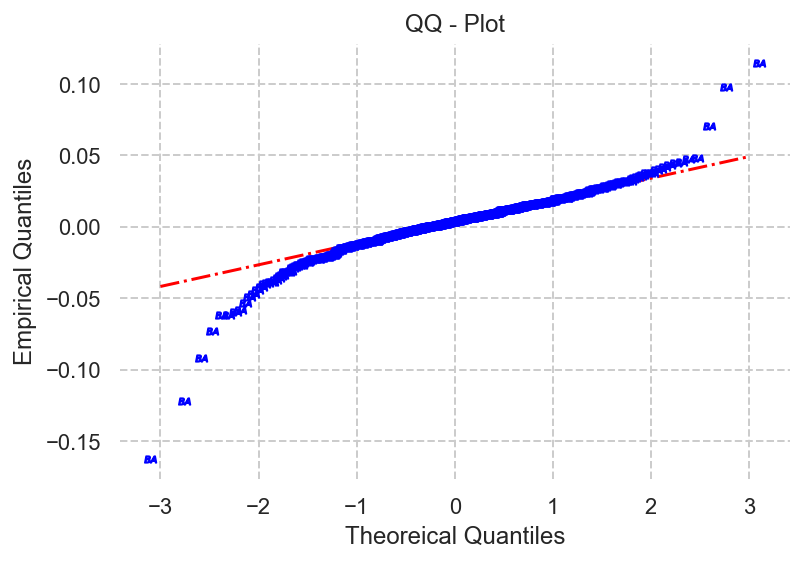

(-0.6744897501960817, 0.6744897501960817)
-0.008476150909525505 0.007772558928690815


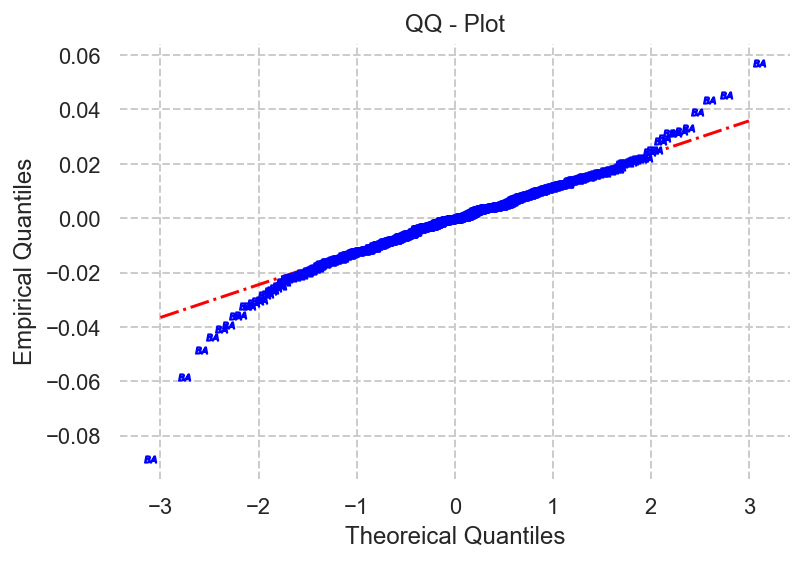

In [138]:
n_spx_observations = len(snp500_weekly_returns)
#n_aud_observations = len(aud_weekly_returns)
observations = snp500_weekly_returns[1:].to_list()

def qq_plot_normal(observations):
    observations.sort()
    n_observations = len(observations)
    normals = [norm.ppf((i-0.5)/n_observations) for i in range(1, n_observations + 1)]
    fig, ax = plt.subplots()
    


    percentiles = (0.25, 0.75)
    (x1, x2) = norm.ppf(percentiles)
    print((x1, x2))
    (y1, y2) = np.percentile(observations, (25, 75))
    print(y1, y2)

    m = (y2-y1)/(x2-x1)
    b = y1-m*x1
    qqline = [m*i+b for i in range(-3, 4)]
    x_ax = range(-3, 4)
    ax.plot(x_ax, qqline, color='red', linestyle='dashdot')
    ax.scatter(normals, observations, marker='$BA$', color='blue', zorder=3, linewidths=0.75)
    plt.xlabel('Theoreical Quantiles')
    plt.ylabel('Empirical Quantiles')
    plt.title('QQ - Plot')
    ax.set_frame_on(False)

    plt.show()



qq_plot_normal(snp500_weekly_returns[1:].to_list())
qq_plot_normal(aud_weekly_returns[1:].to_list())



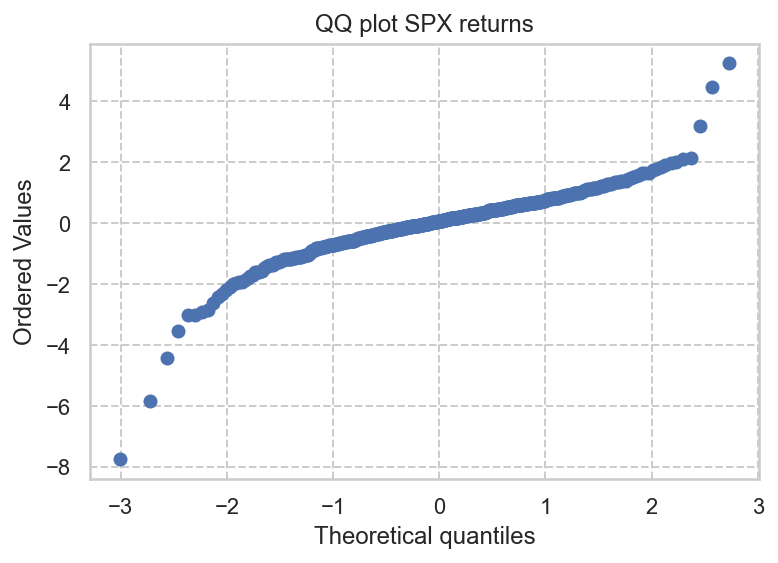

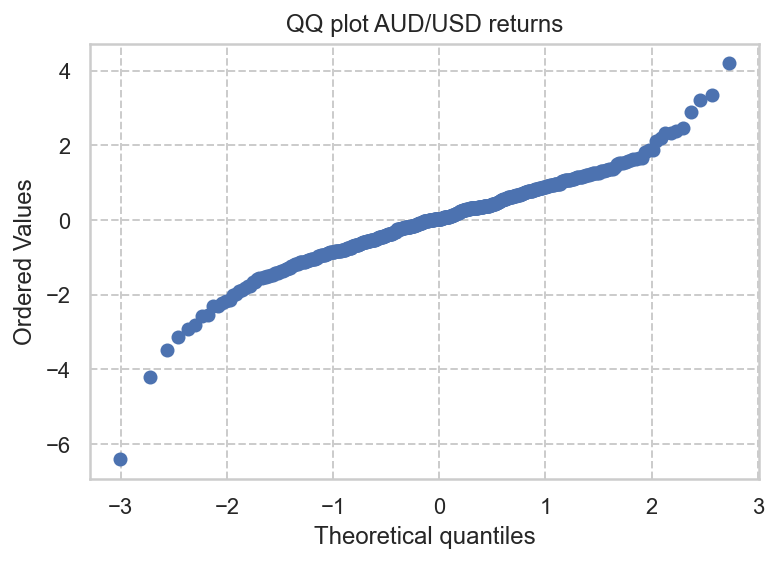

In [83]:
stats.probplot((snp500_weekly_returns-snp500_weekly_returns.mean())/snp500_weekly_returns.std(), dist='norm', plot=plt)
plt.title('QQ plot SPX returns')
plt.show()
stats.probplot((aud_weekly_returns-aud_weekly_returns.mean())/aud_weekly_returns.std(), dist='norm', plot=plt)
plt.title('QQ plot AUD/USD returns')
plt.show()

In [84]:
def standard_vol_estimator(data):

    window_size = len(data)
    average_vol = data.mean()
    sum = 0

    for i in range(window_size):
        sum = sum + (data[(window_size - 1) - i] - average_vol) ** 2

    return np.sqrt(sum / (window_size - 1))  

In [85]:
EqWMA_30wk_AUD = aud_weekly_returns.rolling(30).apply(standard_vol_estimator)
EqWMA_90wk_AUD = aud_weekly_returns.rolling(90).apply(standard_vol_estimator)

EqWMA_30wk_SPX = snp500_weekly_returns.rolling(30).apply(standard_vol_estimator)
EqWMA_90wk_SPX = snp500_weekly_returns.rolling(90).apply(standard_vol_estimator)

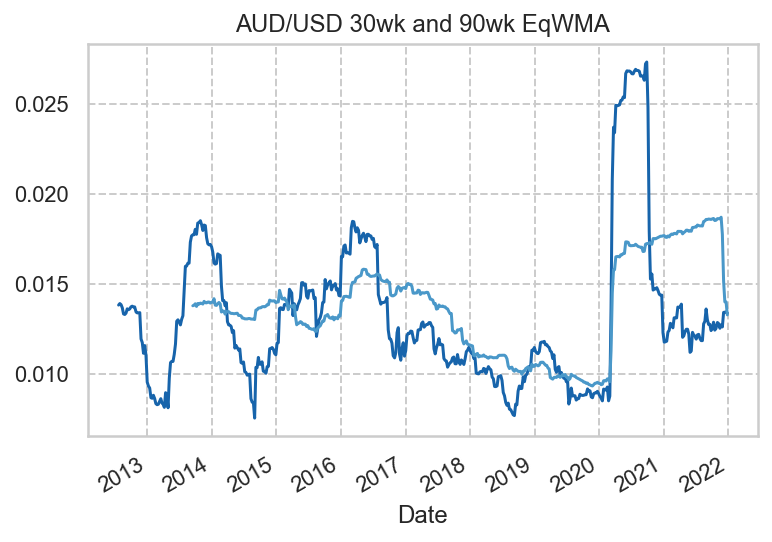

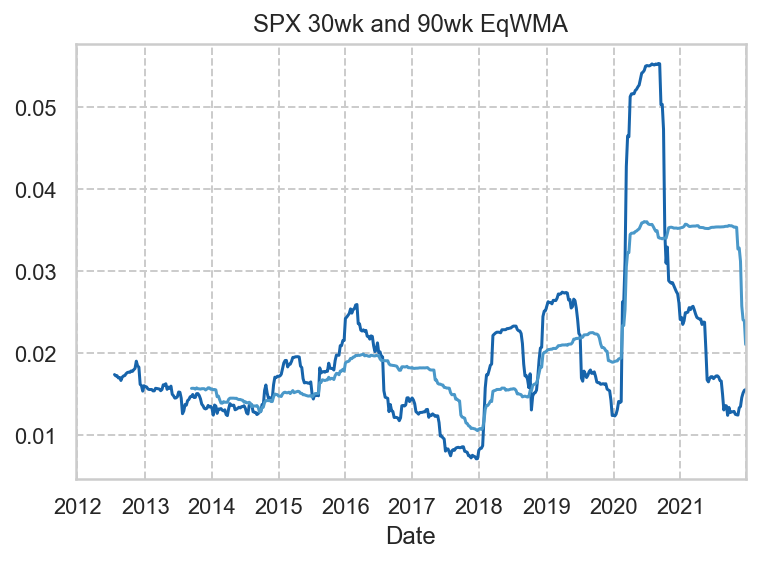

In [86]:
EqWMA_30wk_AUD.plot()
EqWMA_90wk_AUD.plot()
plt.title('AUD/USD 30wk and 90wk EqWMA')
plt.show()
EqWMA_30wk_SPX.plot()
EqWMA_90wk_SPX.plot()
plt.title('SPX 30wk and 90wk EqWMA')
plt.show()

In [87]:
def EWMA_vol_estimator(data):
    
    lam = 0.94 # RiskMetrics rule of thumb. 
    window_size = len(data)
    average = data.mean()
    sum = 0
    for i in range(window_size):
        sum = sum + (lam ** (i-1)) * (data[(window_size - 1) - i] - average) ** 2
    return np.sqrt((1 - lam) * sum)

In [88]:
EWMA_30wk_AUD = aud_weekly_returns.rolling(10).apply(EWMA_vol_estimator)
EWMA_90wk_AUD = aud_weekly_returns.rolling(30).apply(EWMA_vol_estimator)

EWMA_30wk_SPX = snp500_weekly_returns.rolling(10).apply(EWMA_vol_estimator)
EWMA_90wk_SPX = snp500_weekly_returns.rolling(30).apply(EWMA_vol_estimator)

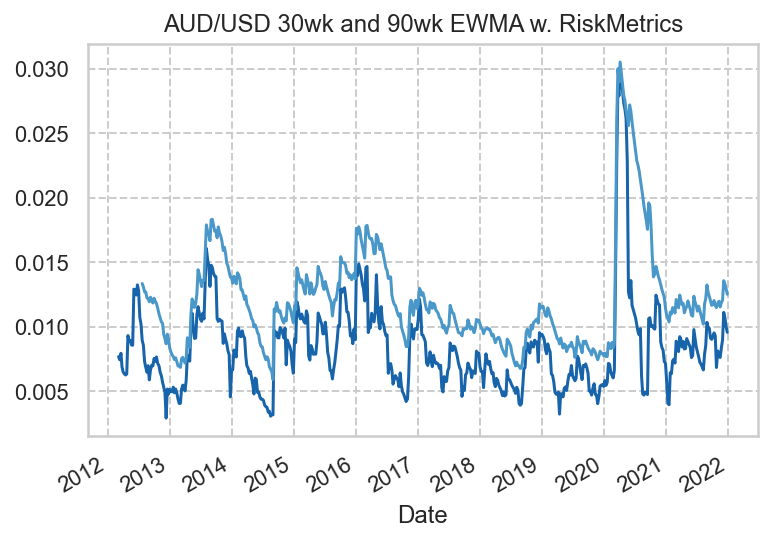

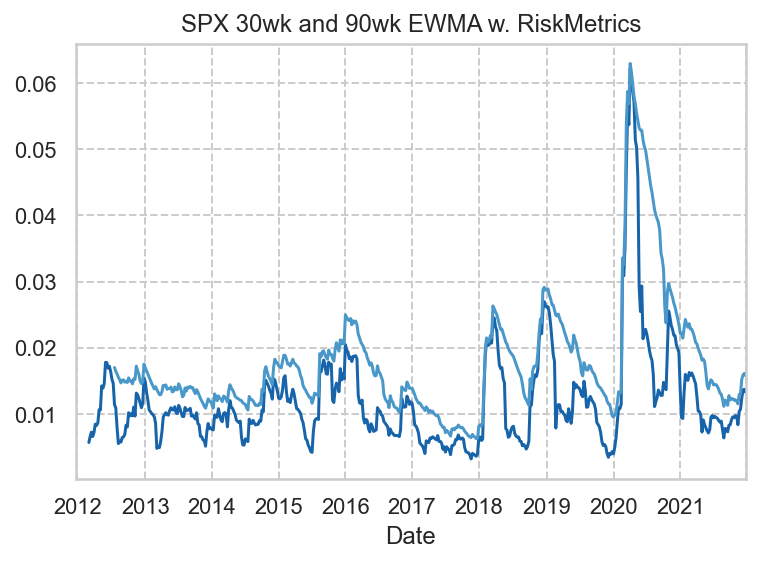

In [89]:
EWMA_30wk_AUD.plot()
EWMA_90wk_AUD.plot()
plt.title('AUD/USD 30wk and 90wk EWMA w. RiskMetrics')
plt.show()

EWMA_30wk_SPX.plot()
EWMA_90wk_SPX.plot()
plt.title('SPX 30wk and 90wk EWMA w. RiskMetrics')
plt.show()

In [90]:
def objective(x):
    
    sum = 0

    vol_init = EqWMA_30wk_AUD[30] ** 2
    return_data = aud_weekly_returns
    n = len(aud_weekly_returns)
    vol_list = [vol_init]

    for i in range(n-7):
        vol = x[0] + x[2] * vol_list[i] + x[1] * return_data[i+7] ** 2
        vol_list.append(vol)
        
    for i in range(len(vol_list)-7):
        sum = sum - np.log(vol_list[i]) - (return_data[i+7] ** 2) / vol_list[i]

    return sum


In [91]:
linear_constraint = LinearConstraint([[0, 0, 0], [0, 1, 1], [0, 0, 0]], lb=[-np.inf, -np.inf, -np.inf], ub=[np.inf, 1, np.inf])

In [92]:
x0 = [0.11, 0.15, 0.05]
minimize(objective, x0)

/var/folders/d7/rpl_88f12ln2z1s2h4m9ybjm0000gn/T/ipykernel_78778/444494377.py:11: RuntimeWarning: overflow encountered in double_scalars
  vol = x[0] + x[2] * vol_list[i] + x[1] * return_data[i+7] ** 2
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/d7/rpl_88f12ln2z1s2h4m9ybjm0000gn/T/ipykernel_78778/444494377.py:11: RuntimeWarning: overflow encountered in double_scalars
  vol = x[0] + x[2] * vol_list[i] + x[1] * return_data[i+7] ** 2
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: -138.75876121954784
 hess_inv: array([[ 5.70264698e-04, -1.87436432e-04,  1.83146695e-02],
       [-1.87436432e-04,  9.99999965e-01,  3.44850351e-06],
       [ 1.83146695e-02,  3.44850351e-06,  1.01758166e+00]])
      jac: array([-4.57114021e+02, -8.62007141e-02, -6.08544754e+02])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 424
      nit: 1
     njev: 103
   status: 2
  success: False
        x: array([1.11332198, 0.15018827, 0.16595242])